In [16]:
import os
from pygmid import Lookup as lk
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import matplotlib as mpl
from time import time
#path = '/home/pedersen/misc/gmid/configs_lv' # this is the path when using in the vm
from pathlib import Path

path_local = Path('C:/Users/pedersen/Desktop/OpenDesingCourse/no_touch_files')

In [17]:
def plot_id_w(device_type, selected_gm_id, selected_L, chosen_vds, current):
    """Plot ID/W vs g_m/ID for the given device type (NMOS or PMOS) with selected parameters.
       Additionally, calculate and return current/id_w_value."""
    
    # Choose the correct lookup based on the device type
    if device_type == 'nmos':
        lookup_fn = nmos_lv.look_up
    elif device_type == 'pmos':
        lookup_fn = pmos_lv.look_up
    else:
        raise ValueError("Invalid device type. Use 'nmos' or 'pmos'.")

    # Lookup ID/W value for the selected GM ID and length
    id_w_value = lookup_fn('ID_W', GM_ID=selected_gm_id, L=selected_L, VDS=chosen_vds)
    
    # Calculate current/id_w_value
    current_id_ratio = current / id_w_value if id_w_value != 0 else None

    # Generate GM IDs for the plot
    gm_ids = np.arange(3, 15 + 0.1, 0.1)
    id_w = lookup_fn('ID_W', GM_ID=gm_ids, L=selected_L, VDS=chosen_vds)

    # Plotting
    plt.figure()
    plt.plot(gm_ids, id_w, label=f'L = {selected_L}')
    plt.axhline(y=id_w_value, color='green', linestyle='--', label=f"$I_D/W={id_w_value:.2e}$")
    plt.plot(selected_gm_id, id_w_value, 'ro')  
    plt.text(selected_gm_id + 0.2, id_w_value, f"$I_D/W={id_w_value:.2e}$", color='green')
    plt.ylabel(r"$I_D/W$")
    plt.xlabel(r"$g_m/I_D$")
    plt.title(rf'$I_D/W$ vs. $g_m/I_D$ for $L = {selected_L}$')
    plt.legend([f'L = {selected_L}']) 
    plt.show()

    return current_id_ratio

def determine_inversion_region(gm_id_value, device_type):
    """Determine the inversion region based on gm/id value for NMOS or PMOS."""
    if device_type == 'nmos':
        if gm_id_value > 20:
            return "Weak Inversion"
        elif 10 < gm_id_value <= 20:
            return "Moderate Inversion"
        else:
            return "Strong Inversion"
    elif device_type == 'pmos':
        if gm_id_value > 20:
            return "Weak Inversion"
        elif 10 < gm_id_value <= 20:
            return "Moderate Inversion"
        else:
            return "Strong Inversion"
    else:
        raise ValueError("Invalid device type. Use 'nmos' or 'pmos'.")


def dB_to_linear(av_db):
    return 10 ** (av_db / 20)

def display_current(Id_value):
    """Determine the current value and its unit."""
    if Id_value < 1e-6:
        return Id_value * 1e9, "nA"  # Convert to nA
    elif Id_value < 1e-3:
        return Id_value * 1e6, "μA"  # Convert to μA
    else:
        return Id_value * 1e3, "mA"   # Convert to mA

def display_resistance(ro_value):
    """Determine the resistance value and its unit."""
    if ro_value < 1e3:
        return ro_value, "Ω"
    elif ro_value < 1e6:
        return ro_value / 1e3, "kΩ"
    elif ro_value < 1e9:
        return ro_value / 1e6, "MΩ"
    else:
        return ro_value / 1e9, "GΩ"


def calculate_missing_resistor(R_eq, R_known):
    """
    Calculate the missing resistor value in a parallel resistor configuration.

    Parameters:
    R_eq (float): The equivalent resistance (R_eq).
    R_known (float): The known resistor value (R1 or R2).

    Returns:
    float: The calculated missing resistor value (R2).
    """
    if R_eq >= R_known:
        raise ValueError("Equivalent resistance must be less than the known resistor.")
    
    # Calculate the missing resistor value
    R_missing = (R_eq * R_known) / (R_known - R_eq)
    return R_missing


def find_length_for_gm_gds(gm_id_target, gm_gds_target):
    idx = np.abs(gm_ids - gm_id_target).argmin()
    gm_gds_at_id = gm_gds[:, idx]  

    interpolation = interp1d(gm_gds_at_id, Ls, bounds_error=False, fill_value="extrapolate")
    length_result = interpolation(gm_gds_target)
    return length_result


In [18]:
pmos_lv = lk(os.path.join(path_local, '130p1vrvt.pkl'))
nmos_lv = lk(os.path.join(path_local, '130n1vrvt.pkl'))

In [19]:
# setup mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams.update({"axes.grid" : True})

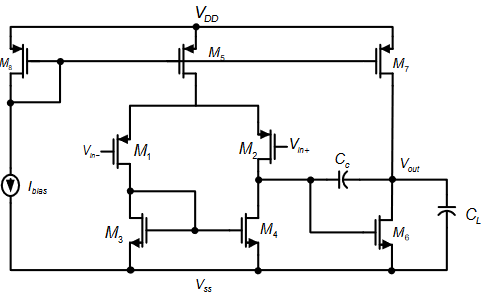

# Specs

In [20]:
vdd = 1.2 # supply voltage
Cl = 1e-12 # load capacitance
current_max = 500e-6 # maximum current
Av = 75 # DC gain
GBW = 25e6 # gain bandwidth product
phase_margin = 60 # phase margin in degrees
slew_rate = 25e6 # slew rate in V/s

# Setting the gmid to barely meet the GBW and the SR of the input pairs

$$GBW = \frac{1}{2}\left(\frac{g_{m1}}{I_{D1}}\right) \cdot SR $$

In [26]:
gmid_12 = (2*(2*np.pi*GBW))/(slew_rate)
print(f'gmid_12 = {gmid_12:} which places the transistor in ' + determine_inversion_region(gmid_12, 'nmos'))

gmid_12 = 12.56637061435917 which places the transistor in Moderate Inversion
